<a href="https://colab.research.google.com/github/DaniyalMirza99/DaniyalMirza99/blob/main/Copy_of_Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import all the Dependencies
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
#Set all the Constants
BATCH_SIZE = 32
IMAGE_SIZEW = 480
IMAGE_SIZEH=720
CHANNELS=3
EPOCHS=5

In [ ]:
#We will use image_dataset_from_directory api to load all images in tensorflow dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/fyp/disease",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZEW,IMAGE_SIZEH),
    batch_size=32
)

Found 775 files belonging to 4 classes.


In [ ]:

class_names = dataset.class_names
class_names

['Acne and Rosacea',
 'Eczema',
 'Exanthems and Drug Eruptions',
 'Urticaria Hives']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 480, 720, 3)
[1 0 0 1 1 0 0 1 1 0 1 1 0 1 2 1 1 1 0 0 0 2 0 3 1 1 1 1 0 1 0 3]


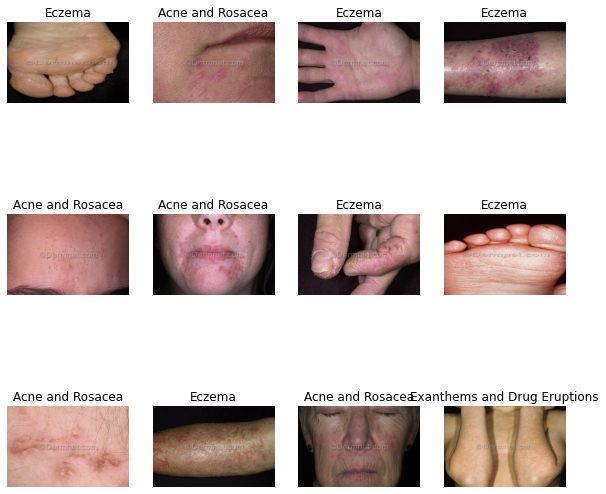

In [ ]:
#Visualize some of the images from our dataset
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
#Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZEW, IMAGE_SIZEW),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZEW, IMAGE_SIZEW, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 480, 480, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 478, 478, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 239, 239, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 237, 237, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 118, 118, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 116, 116, 64)       

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5,
)

Epoch 1/5
20/20 [==============================] - 321s 13s/step - loss: 1.2498 - accuracy: 0.3967 - val_loss: 1.1800 - val_accuracy: 0.4062
Epoch 2/5
20/20 [==============================] - 257s 13s/step - loss: 1.2010 - accuracy: 0.4049 - val_loss: 1.1575 - val_accuracy: 0.4062
Epoch 3/5
20/20 [==============================] - 261s 13s/step - loss: 1.1888 - accuracy: 0.3951 - val_loss: 1.1365 - val_accuracy: 0.4219
Epoch 4/5
20/20 [==============================] - 259s 13s/step - loss: 1.1983 - accuracy: 0.3886 - val_loss: 1.1844 - val_accuracy: 0.4219
Epoch 5/5
20/20 [==============================] - 261s 13s/step - loss: 1.1973 - accuracy: 0.3984 - val_loss: 1.1698 - val_accuracy: 0.4062


In [ ]:
scores = model.evaluate(test_ds)

3/3 [==============================] - 15s 3s/step - loss: 1.2173 - accuracy: 0.2917


In [ ]:
scores

[1.2172917127609253, 0.2916666567325592]

In [ ]:
history

In [ ]:
history.params

{'epochs': 5, 'steps': 20, 'verbose': 1}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
type(history.history['loss'])

list

In [ ]:

len(history.history['loss'])

5

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.2497844696044922,
 1.2010002136230469,
 1.1887717247009277,
 1.1982886791229248,
 1.1972609758377075]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

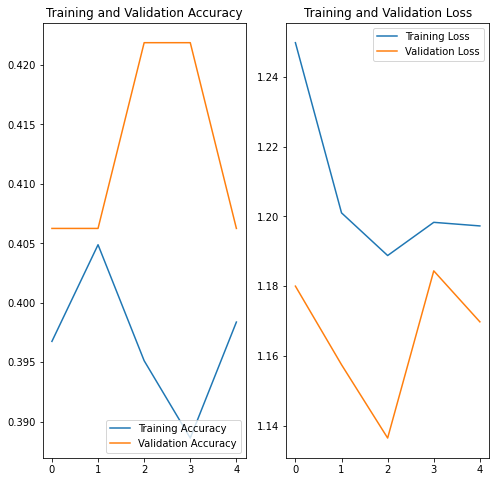

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Acne and Rosacea
predicted label: Acne and Rosacea


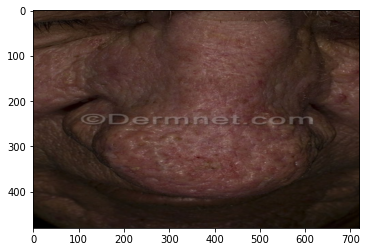

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[10].numpy().astype('uint8')
    first_label = labels_batch[2].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

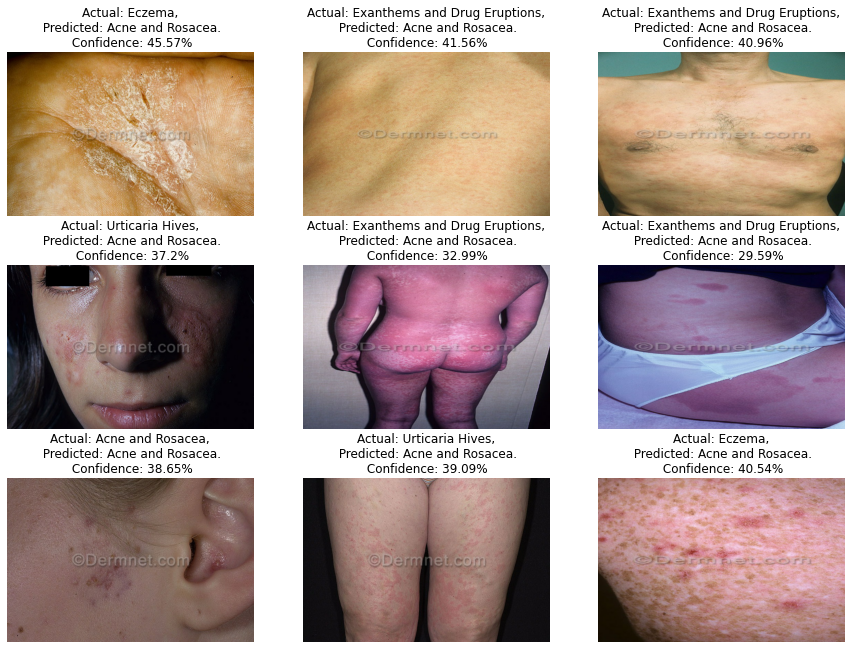

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("/content/drive/MyDrive/fyp/models") + [0]])+1
model.save(f"/content/drive/MyDrive/fyp/models{model_version}")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/fyp/models1/assets


In [ ]:
model.save("../diseases.h5")